<br>
<br>
<br>
<div style="text-align: center;">
  <img src="Images/Finetuned.jpg" alt="Finetuned">
</div>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


<div style="text-align: center;">
  <img src="Images/Fewshot.jpg" alt="Fewshot">
</div>
<br>
<br>
<br><br>
<br>
<br><br>
<br>
<br><br>
<br><br>
<br>
<br>
<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import random
import sys
import os
import importlib
import utils
import matplotlib.pyplot as plt
import numpy as np
import warnings

current_folder = os.getcwd()
if current_folder not in sys.path:
    sys.path.append(current_folder)
from utils import few_shot_comparison, plot_tsne
from collections import defaultdict
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Few-Shot Learning: Introduction

**What is Few-Shot Learning?**

Traditional supervised learning relies on large datasets with many labeled examples per class. In contrast, **few-shot learning (FSL)** aims to learn new concepts from **very few labeled examples**, sometimes as few as 1–5 per class. 

## Why Few-Shot Learning Is Useful

Few-shot learning is designed for scenarios where standard supervised learning is impractical or inefficient. 
Below are the main reasons why few-shot methods are important in real-world machine learning systems.

---

### 1. Data Is Expensive or Hard to Collect

In many domains, collecting large labeled datasets is not feasible.

Examples:
- **Medical imaging:** Labeling an image may require a trained radiologist or pathologist.
- **Rare diseases:** There may be only a handful of available patient cases.
- **Wildlife monitoring:** Some species are rare, endangered, or difficult to photograph.
- **Industrial defects:** Failures are rare by definition, so examples are scarce.

In such settings:
- Collecting thousands of labeled examples per class is unrealistic.
- Traditional deep learning models overfit when trained on very small datasets.

Few-shot learning addresses this by:
- Relying on **prior knowledge learned from other data**
- Requiring only a few labeled examples to recognize a new class

**The key assumption is that the model has already learned *how to represent the domain*, 
and the few examples only specify what is new.**

---

### 2. Rapid Adaptation to New Tasks Is Needed

In many applications, new categories appear frequently and models must adapt quickly.

Examples:
- **Personalized systems:** A model adapts to a new user's preferences.
- **Security systems:** New attack patterns or anomalies appear.
- **Robotics:** A robot encounters new objects or environments.
- **Content moderation:** New types of content or trends emerge.

In these cases:
- Retraining a large model from scratch is slow and computationally expensive.
- Collecting large datasets for each new task is impractical.

Few-shot learning allows:
- Adding new classes using only a few examples
- Avoiding full retraining of the model
- Near-instant adaptation at deployment time

This makes few-shot learning suitable for **on-the-fly learning**.

---

### 3. Leveraging Pre-Existing Knowledge Efficiently

Few-shot learning is built on the idea that models should reuse what they already know.

Modern machine learning models are often:
- Pretrained on massive datasets
- Rich in general-purpose representations

Examples:
- Vision models pretrained on ImageNet
- Language models pretrained on large text corpora
- Speech models pretrained on large audio datasets

Few-shot learning leverages this by:
- Keeping the pretrained representation fixed
- Using a small number of examples to define new tasks in that representation space

Instead of learning from scratch:
- The model uses similarity, distance, or contextual cues
- Knowledge transfers from old tasks to new ones

This leads to:
- Better generalization
- Lower data requirements
- More efficient use of computational resources

---

### Summary

Few-shot learning is useful when:
- Large labeled datasets are unavailable
- Fast adaptation is required

In short, few-shot learning shifts the focus from *learning from data* to *using knowledge effectively*.


---

**Key Concepts**

- **N-way K-shot learning:**  
  - **N** = number of classes to classify  
  - **K** = number of labeled examples per class  
  Example: 5-way 1-shot = classify among 5 classes, 1 labeled example per class  

- **Support Set:** the small labeled dataset used for learning  
- **Query Set:** the dataset of new/unseen examples to classify  



# Metric-Based Few-Shot Learning

**Goal:**  
Classify new examples when you have **very few labeled examples per class**. Instead of training a full classifier from scratch, you learn a **feature space (embedding space)** where you can measure similarity between examples.

---

Examples of Metric-Based Approaches

**Prototypical Networks**: use the mean embedding as the prototype.

**Matching Networks**: compare query embeddings to all support embeddings with attention-weighted similarity.

**Siamese Networks**: learn a network that directly predicts if two examples are from the same class (distance learning).

---

## Prototypical Networks Key Idea

1. **Embed all examples into a feature space**  
   - A neural network (or other function) maps each input $x$ to an embedding $f(x)$.  
   - Ideally, embeddings of the **same class are close**, and embeddings of **different classes are far apart**.

2. **Compute a "prototype" for each class**  
   - For each class $c$, compute the **average embedding** of the support examples:  
     
     $$
     \mathbf{p}_c = \frac{1}{K} \sum_{i=1}^{K} f(x_i^c)
     $$
     
     where $x_i^c$ is the $i$-th support example of class $c$, and $K$ is the number of support examples per class.  
   - Think of this as the **center of the cluster** in embedding space.

3. **Classify query examples**  
   - For a new (query) example $x_q$, compute its embedding $f(x_q)$.  
   - Measure the distance to each prototype (usually **Euclidean** or **cosine similarity**).  
   - Assign $x_q$ to the class of the **nearest prototype**.

---

## Intuition / Visualization

- Imagine a 2D plot:  
  - Each point = an example  
  - Points from the same class cluster together  
  - Prototypes = black stars at the center of each cluster  
  - Query points = classified by "nearest star"  

- Even with **just 1-5 examples per class**, if the embedding space is well-structured, you can classify correctly.

---

## Why Metric-Based Works in Few-Shot Learning

1. **No need to retrain a large classifier** – you just compare distances.  
2. **Leverages learned feature representations** – you can pretrain the embedding network on other data.  
3. **Scalable to new classes** – adding a new class is just computing its prototype; no extra training.  

---

**In short:** Metric-based few-shot learning is **“learn a good embedding space, then classify by distance”**.


**Prototypical Networks:** compute a "prototype" for each class by averaging support embeddings.  
- Classify a query sample based on nearest prototype in embedding space.  
- Advantages: simple, intuitive, often works well with pre-trained embeddings.  

**Intuition:**  
Imagine a 2D plot where points represent features of examples:
- Points from the same class cluster together
- Prototypes are the "center" of each cluster
- New points are classified based on proximity to these centers
  


Real-life data example:

In [2]:
n_way = 4
k_shot = 5
n_query = 5

In [3]:
transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [4]:
# Pick n_way random classes
classes = random.sample(range(10), n_way)

# Sample k_shot + n_query examples per class
support_x, support_y, query_x, query_y = [], [], [], []

for c in classes:
    idxs = [i for i, label in enumerate(dataset.targets) if label == c]
    sampled = random.sample(idxs, k_shot + n_query)
    for i, s in enumerate(sampled):
        img, label = dataset[s]
        if i < k_shot:
            support_x.append(img)
            support_y.append(classes.index(label))
        else:
            query_x.append(img)
            query_y.append(classes.index(label))

support_x = torch.stack(support_x).to(device)
support_y = torch.tensor(support_y).to(device)
query_x = torch.stack(query_x).to(device)
query_y = torch.tensor(query_y).to(device)


In [5]:
# backbone model 
model = torchvision.models.resnet18(weights=True) 
model.fc = nn.Identity() 
model = model.to(device) 
model.eval()

with torch.no_grad():
    # embeddings
    support_embeds = model(support_x.to(device)) 
    query_embeds   = model(query_x.to(device))   


In [6]:
#Nearest Neighbor
dists = torch.cdist(query_embeds, support_embeds)  

nn_idx = dists.argmin(dim=1)

logits_pre = support_y[nn_idx]   
pre_preds  = logits_pre
pre_acc    = (pre_preds == query_y).float().mean().item()

In [7]:
# Prototypical Network
support_y = support_y.to(support_embeds.device)

with torch.no_grad():
    prototypes = torch.stack([
        support_embeds[support_y == c].mean(dim=0)
        for c in range(n_way)
    ])

    dists = torch.cdist(query_embeds, prototypes)
    post_preds = dists.argmin(dim=1)

    post_acc = (post_preds.to(device) == query_y).float().mean().item()

In [8]:
few_shot_comparison("Baseline - Nearest Neighbor", "Prototypical Network", pre_acc, post_acc, n_way, k_shot, n_query)

Few-Shot Learning Performance Comparison
----------------------------------------
N-way: 4, K-shot: 5, Queries/class: 5

Before few-shot (Baseline - Nearest Neighbor): 0.45
After few-shot (Prototypical Network):    0.75

Gain from few-shot learning: +0.30


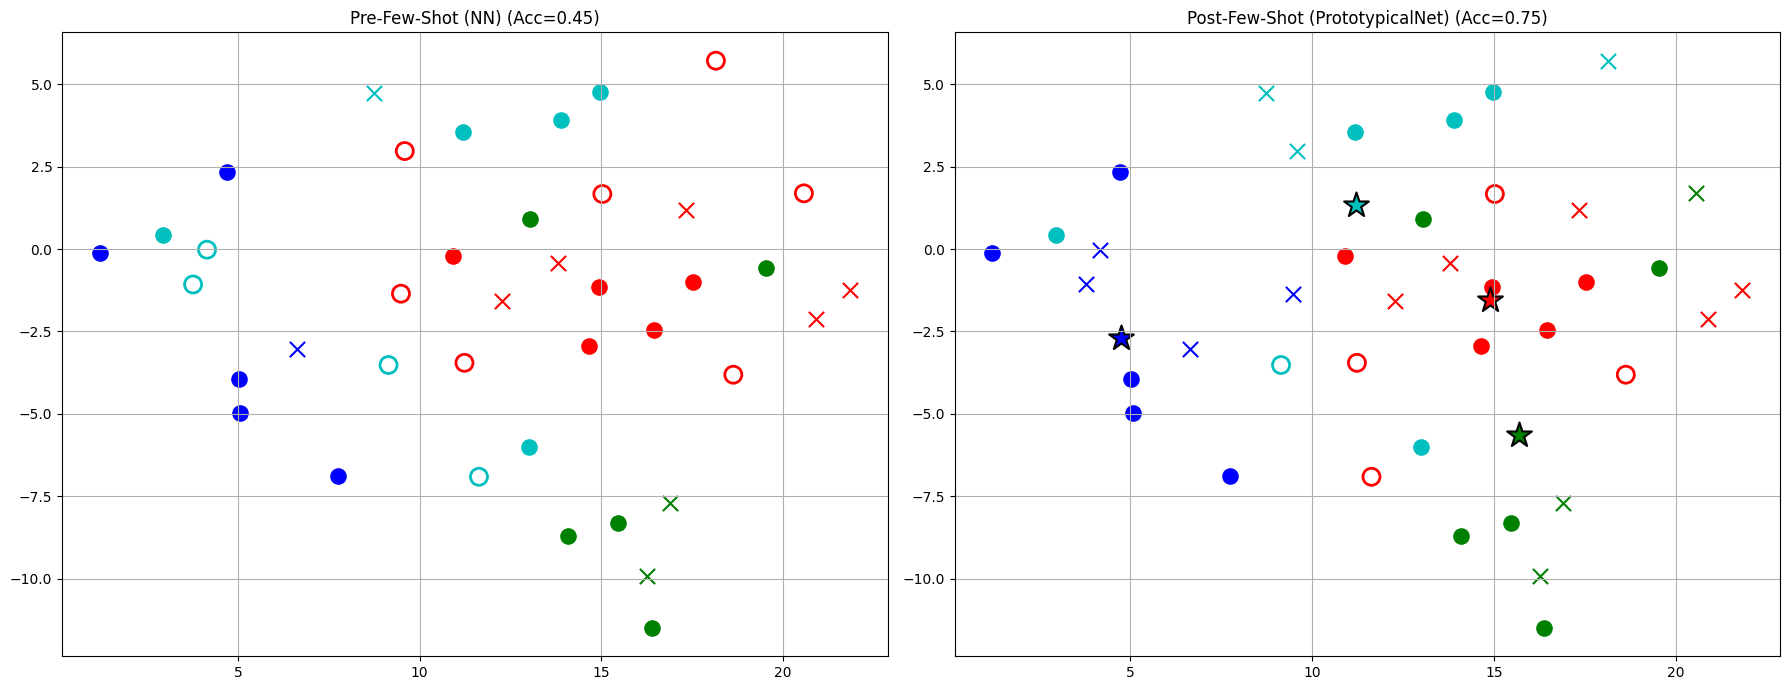

In [9]:
all_embeds = torch.cat([support_embeds, query_embeds], dim=0).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_embeddings_2d = tsne.fit_transform(all_embeds)

num_support = support_embeds.shape[0]
support_2d = tsne_embeddings_2d[:num_support]
query_2d   = tsne_embeddings_2d[num_support:]

# Compute prototypes in 2D for t-SNE 
support_y_np = support_y.cpu().numpy()

prototypes_2d = np.stack([
    support_2d[support_y_np == c].mean(axis=0)
    for c in range(n_way)
])


fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Nearest Neighbor 
plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

# Prototypical Network
plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (PrototypicalNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
    show_prototypes=True,
    prototypes_2d=prototypes_2d
)

plt.tight_layout()
plt.show()

#stars - prototypes
#circles - support points
#rings - misclassified query points
#x-es - well classified query points

## Matching Networks: Attention over Support Set

Matching Networks are a few-shot learning approach that extends the ideas of Prototypical Networks by comparing each query example to **all support examples** rather than computing a single prototype per class. This allows the model to capture more detailed relationships in the support set, which can be especially helpful when classes are diverse or have complex distributions.

### Key Ideas

- **Support Set Comparison:**  
  Each query embedding is compared to **every support embedding** using a similarity function (e.g., cosine similarity or dot product).

- **Attention-Weighted Prediction:**  

  In Matching Networks, a query is compared to **all support examples**. The prediction is a **weighted sum of the support labels**, where the weights are determined by similarity to the query.

  Let $q$ be a query example and $S = \{(x_i, y_i)\}$the support set. Then the predicted label is:

  $$
  \hat{y}_q = \sum_{i \in S} a(q, x_i) \, y_i
  $$

  The attention weights $a(q, x_i)$ are computed as a softmax over similarities:

  $$
  a(q, x_i) = \frac{\exp(\text{sim}(f(q), f(x_i)))}{\sum_{j \in S} \exp(\text{sim}(f(q), f(x_j)))} \,,
  $$

  where:  
  - $f(\cdot)$ is the embedding function (e.g., CNN).  
  - $\text{sim}(\cdot, \cdot)$ is a similarity function (commonly **cosine similarity** or **dot product**).  
  - $y_i$ is the label of support example $x_i$ (usually one-hot encoded).  

  This allows the query to **attend to the most relevant support examples**, weighting their influence in the final prediction.

  Predicted label:   $argmax(\hat{y}_q)$


- **Contextual Embeddings (Optional Advanced):**  
  In the original Matching Networks paper, embeddings can be **contextualized** using a BiLSTM over the support set. This allows each embedding to depend on the rest of the support set, potentially improving performance.

### Comparison with Prototypical Networks

| Feature | Prototypical Network | Matching Network |
|---------|--------------------|----------------|
| Class Representation | Prototype (mean) | All support points |
| Query Comparison | Query ↔ Prototype | Query ↔ All support embeddings (attention) |
| Flexibility | Limited to class mean | Can handle heterogeneous or overlapping classes better |
| Complexity | Lower | Higher (more pairwise computations) |

### Advantages of Matching Networks

- Captures finer-grained information from the support set.
- Can adapt better when class distributions are complex.
- Visualizable attention weights provide insight into which support points influence predictions.

### Applications

- Synthetic datasets for teaching few-shot concepts.
- Pretrained CNN embeddings for real datasets like CIFAR-10.
- Useful baseline to compare with Prototypical Networks and other metric-based few-shot methods.


In [10]:
# Matching Network
query_norm = F.normalize(query_embeds, dim=1)
support_norm = F.normalize(support_embeds, dim=1)

sim_matrix = torch.matmul(query_norm, support_norm.T)

attention = torch.softmax(sim_matrix, dim=1)

support_onehot = torch.zeros(support_y.size(0), n_way).to(device)
support_onehot[torch.arange(support_y.size(0)), support_y] = 1

post_preds = attention.to(device) @ support_onehot.to(device)
post_preds = post_preds.argmax(dim=1)

post_acc = (post_preds == query_y).float().mean().item()

In [11]:
print("Few-Shot Learning Performance Comparison")
print("----------------------------------------")
print(f"N-way: {n_way}, K-shot: {k_shot}, Queries/class: {n_query}")
print()
print(f"Before few-shot (Nearest Neighbor baseline): {pre_acc:.2f}")
print(f"After few-shot (Prototypical):     {post_acc:.2f}")
print()
print("Gain from few-shot learning: "
      f"{post_acc - pre_acc:+.2f}")


Few-Shot Learning Performance Comparison
----------------------------------------
N-way: 4, K-shot: 5, Queries/class: 5

Before few-shot (Nearest Neighbor baseline): 0.45
After few-shot (Prototypical):     0.65

Gain from few-shot learning: +0.20


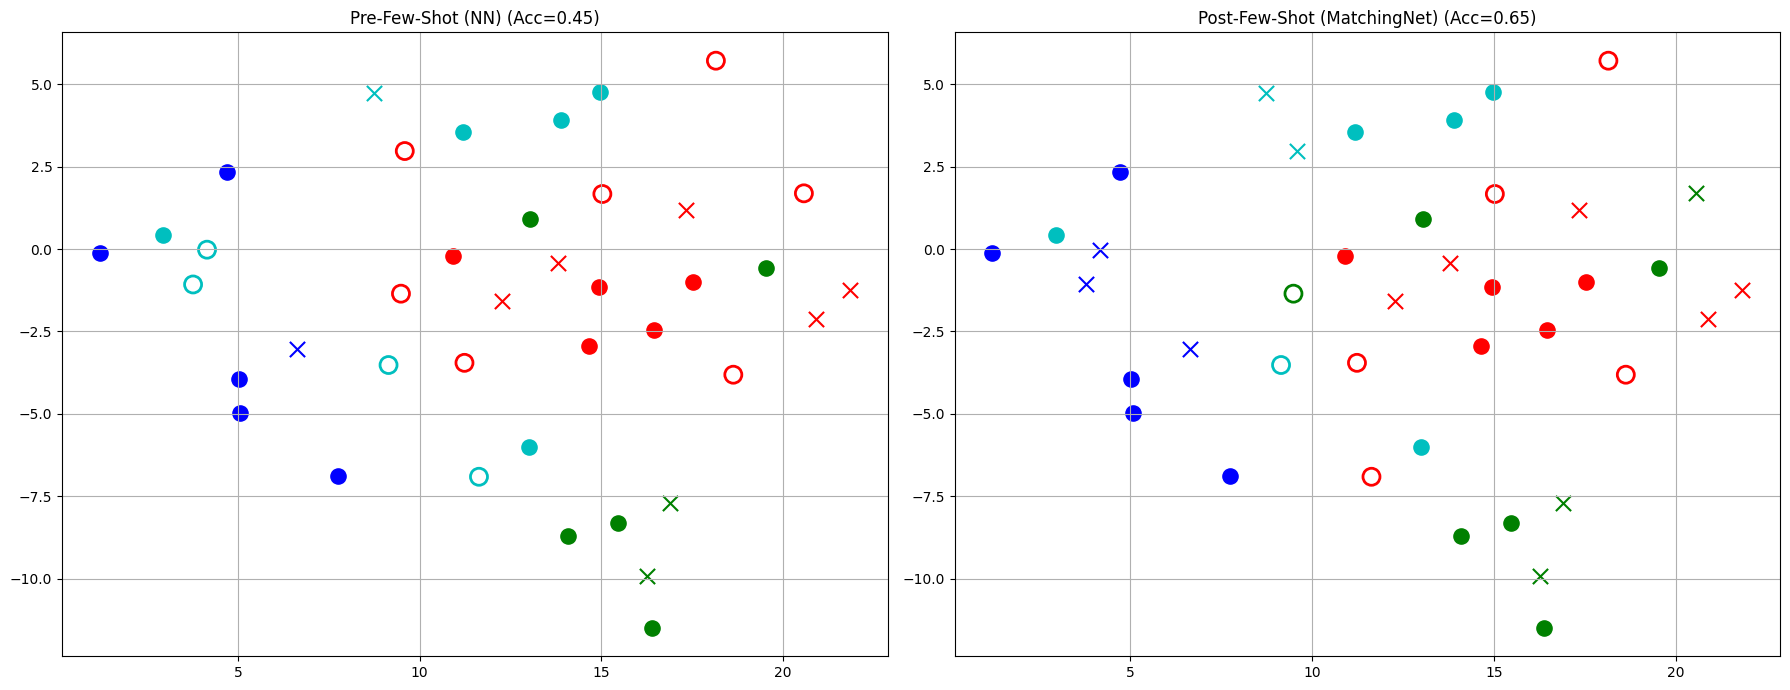

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (MatchingNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
    prototypes_2d=prototypes_2d
)

plt.tight_layout()
plt.show()

#circles - support points
#rings - misclassified query points
#x-es - well classified query points

## Siamese Networks: Pairwise Similarity Learning

Siamese Networks are a few-shot learning approach that focuses on **learning a similarity function** between pairs of examples, rather than directly predicting class labels. This allows the model to generalize to unseen classes by comparing a query to known examples in a flexible way.

### Key Ideas

- **Pairwise Comparison:**  
  The network takes **two inputs at a time** and outputs a similarity score (or distance).  
  The question it answers is: “Are these two examples from the same class?”

- **Shared Embedding Network:**  
  Both inputs pass through the **same embedding network** \(f_\theta(\cdot)\), so that their embeddings live in the same feature space.

  Let \(x_1, x_2\) be two examples, then:
  $$
  h_1 = f_\theta(x_1), \quad h_2 = f_\theta(x_2)
  $$

- **Similarity Function:**  
  A distance or similarity metric (e.g., L1, L2, cosine) is applied to the embeddings:
  $$
  d(x_1, x_2) = \| h_1 - h_2 \|_1 \quad \text{or} \quad d(x_1, x_2) = \text{cosine}(h_1, h_2)
  $$

- **Training with Contrastive Loss:**  
  Pairs of examples are labeled as **similar (same class)** or **dissimilar (different class)**.  
  The network is trained to **minimize distance for similar pairs** and **maximize distance for dissimilar pairs**.  

  Example: Contrastive loss:
  $$
  \mathcal{L} = y \cdot d(x_1, x_2)^2 + (1-y) \cdot \max(0, m - d(x_1, x_2))^2
  $$
  where:  
  - \(y = 1\) if same class, else 0  
  - \(m\) = margin for dissimilar pairs  

- **Prediction:**  
  At test time, a query is compared to support examples.  
  The class of the **most similar support example** (nearest neighbor) is assigned to the query.

---

### Comparison with Prototypical and Matching Networks

| Feature | Prototypical Network | Matching Network | Siamese Network |
|---------|--------------------|----------------|----------------|
| Class Representation | Prototype (mean) | All support points | Pairwise embeddings |
| Query Comparison | Query ↔ Prototype | Query ↔ All support embeddings (attention) | Query ↔ Individual support example (nearest neighbor) |
| Flexibility | Limited | High | Very high, works for unseen classes |
| Complexity | Low | Medium | Medium |
| Training Target | Class centroids | Attention-weighted labels | Pairwise similarity (contrastive) |

---

### Advantages of Siamese Networks

- Can **generalize to unseen classes** easily.
- Learns a **class-agnostic similarity function**.
- Requires only **pair labels**, not full class information.
- Flexible: works even when only **one example per class** is available.

---

### Applications

- Signature verification (original application)
- Face verification (e.g., one-shot face ID)
- Medical imaging: compare patches or slides
- Baseline for metric-based few-shot methods


In [13]:
# Siamese Network
support_norm = F.normalize(support_embeds, dim=1)  
query_norm   = F.normalize(query_embeds, dim=1)    

sim_matrix = torch.matmul(query_norm, support_norm.T)  

max_indices = sim_matrix.argmax(dim=1) 
post_preds = support_y[max_indices]

post_acc = (post_preds == query_y).float().mean().item()


In [14]:
print("Few-Shot Learning Performance Comparison")
print("----------------------------------------")
print(f"N-way: {n_way}, K-shot: {k_shot}, Queries/class: {n_query}\n")

print(f"Before few-shot (Nearest Neighbor baseline): {pre_acc:.2f}")
print(f"After few-shot (Siamese Networks):          {post_acc:.2f}\n")

print("Gain from few-shot learning: "
      f"{post_acc - pre_acc:+.2f}")


Few-Shot Learning Performance Comparison
----------------------------------------
N-way: 4, K-shot: 5, Queries/class: 5

Before few-shot (Nearest Neighbor baseline): 0.45
After few-shot (Siamese Networks):          0.55

Gain from few-shot learning: +0.10


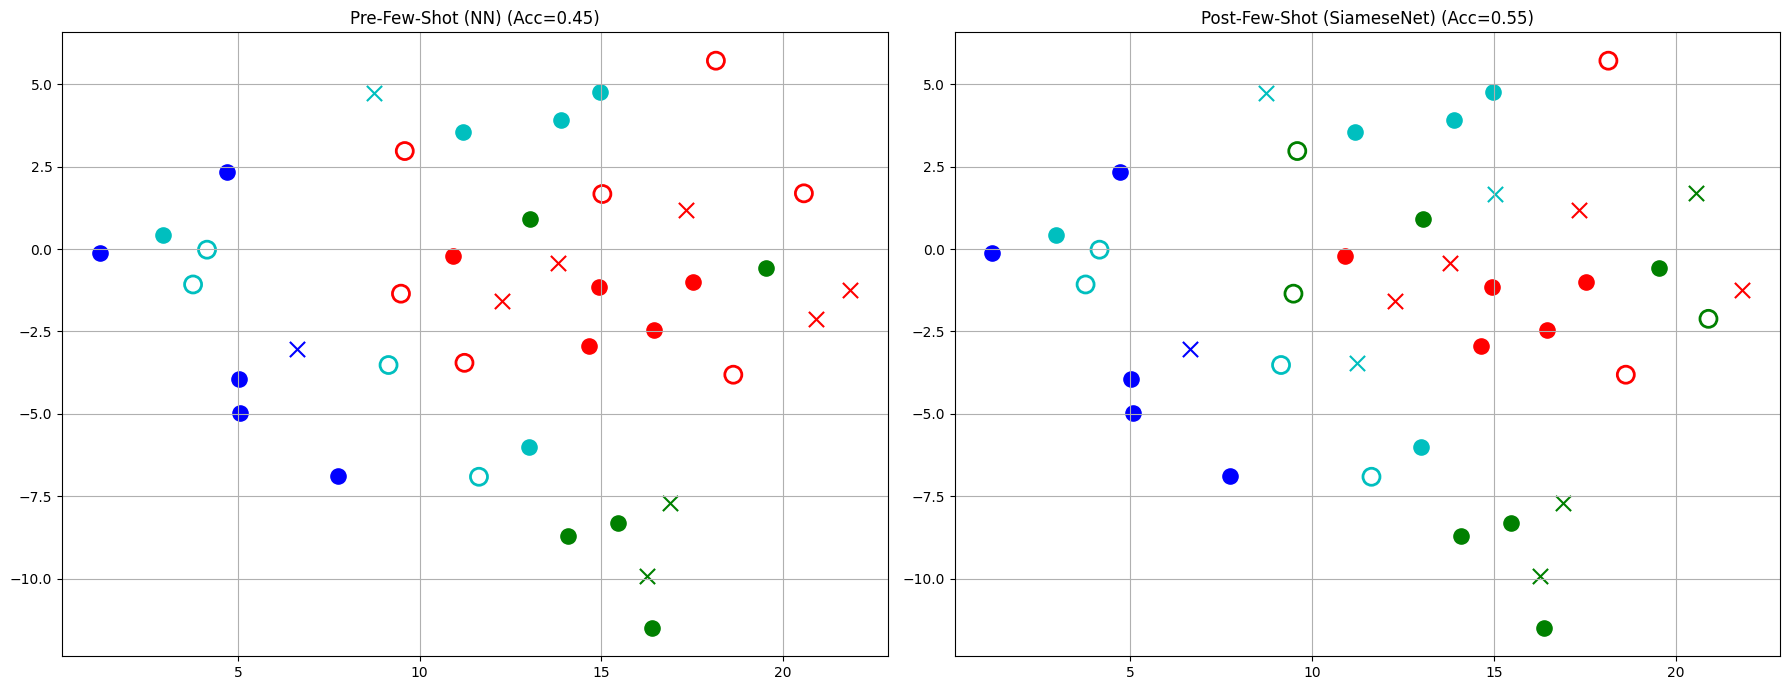

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_tsne(
    axes[0],
    pre_preds.cpu().numpy(),
    f"Pre-Few-Shot (NN) (Acc={pre_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y
)

plot_tsne(
    axes[1],
    post_preds.cpu().numpy(),
    f"Post-Few-Shot (SiameseNet) (Acc={post_acc:.2f})",
    n_way,
    support_2d,
    query_2d,
    support_y_np,
    query_y,
    prototypes_2d=prototypes_2d
)

plt.tight_layout()
plt.show()

#circles - support points
#rings - misclassified query points
#x-es - well classified query points

Exercise 1; answear the question: 

Why do some points in the t-SNE visualization appear to be surrounded by points of the same class but are still marked as misclassified? In other words, why do points that visually seem “in the right cluster” still have incorrect predicted labels? (list at least 2 reasons).